---
title: Sentinel-2 L1C MSI Zarr Product Exploration
subtitle: Explore how to open, visualise and plot Sentinel-2 L1C MSI EOPF Zarr format
authors:
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Suriyah Dhinakaran
    orcid: 0009-0007-0355-7372
    github: suriyahgit
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-03-21
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords : earth and related environmental sciences
releaseDate: 2025-03-21
datePublished: 2025-03-21
dateModified: 2025-03-21
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents
1. [Introduction](#Introduction)  
2. [Import modules](#Import-modules)  
3. [Open the product](#Open-the-product)  
4. [Overview of the product content](#Overview-of-the-product-content)  
5. [Plot a RGB image](#Plot-a-RGB-image)  
6. [Explore product geolocation](#Explore-product-geolocation)  
   A. [Interactive map](#Interactive-map)  
   B. [Non-interactive map](#Non-interactive-map)  
7. [Compute radiances](#Compute-radiances)
8. [Visualization](#Visualization)


## Introduction

This notebook demonstrates how to open, explore, and visualize Sentinel-2 Level 1C MSI products stored in EOPF Zarr format, including plotting RGB images and analyzing geolocation data.

:::{hint} Overview
**Questions**
- How do I access Sentinel-2 L1C in EOPF Zarr format?
- How can I plot the Sentinel-2 tile location on a map?
- How do I plot a RGB image of the selected scene?
- How do I compute radiances from reflectance values?

**Objectives**
- Being able to open a Sentinel-2 L1C EOPF Zarr product from an object storage
- Understanding the product structure and how to get specific bands
- Being able to compute radiances using the available metadata
:::

## Import modules

In [2]:
from eopf.product.eo_variable import EOVariable
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Open the product


In [3]:
remote_product_path = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr"
dt = xr.open_datatree(remote_product_path, engine="zarr", chunks={})

## Overview of the product content

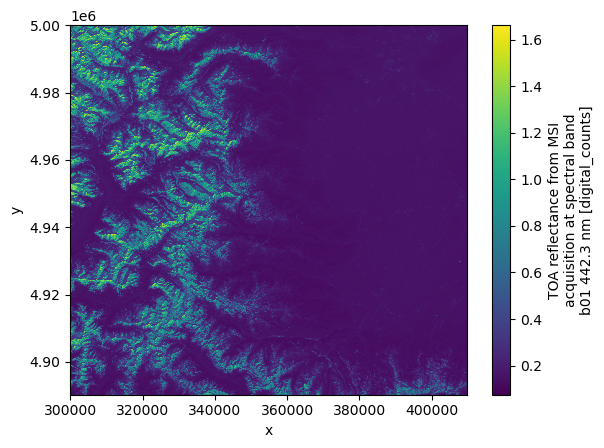

In [4]:
dt["measurements/reflectance/r60m"]["b01"].plot()
# Alternative notation
# dt.measurements.reflectance.r60m.b01.plot()

The original data was stored in `uint16`, with scale and offset values to be applied.  
In this case, the Zarr contains already reflectance values, which means that the scale and offset are already applied to the data.  
We can get some info about the encoding with the following code:

In [5]:
dt["measurements/reflectance/r60m"]["b01"].encoding

{'chunks': (305, 305),
 'preferred_chunks': {'y': 305, 'x': 305},
 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': 0,
 'scale_factor': 0.0001,
 'add_offset': -0.1,
 'dtype': dtype('uint16')}

If we are interested in some band statistics, they can easily be computed using the xarray methods.  
Remember that calling `.compute()` triggers the data download and processing of the result.

In [6]:
min, max, mean = (
    dt["measurements/reflectance/r60m"]["b01"].data.max(),
    dt["measurements/reflectance/r60m"]["b01"].data.min(),
    dt["measurements/reflectance/r60m"]["b01"].data.mean(),
)
min.compute(), max.compute(), mean.compute()

(1.6631, 0.0746, 0.27504428200304576)

## Plot a RGB image


We can compose a new object for visualization, taking only the red (b04), green (b03) and blue (b02) bands.

Decimation is also applied, which reduces the data we consider for visualization, speeding up the process. Decimation is performed using the `.isel` xarray method.
```python
.isel(x=slice(None, None, 10), y=slice(None, None, 10))
```

Finally, we rescale the data for a more meaningful visualization.

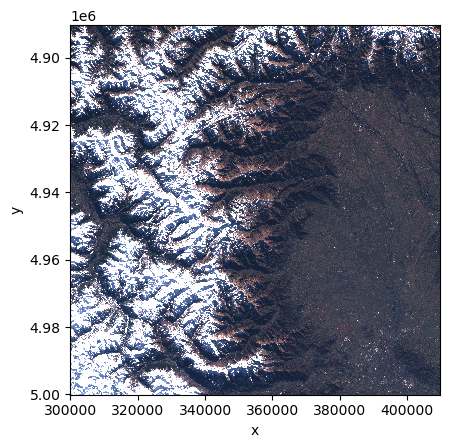

In [7]:
rgb_band_paths = (
    "measurements/reflectance/r10m/b04",
    "measurements/reflectance/r10m/b03",
    "measurements/reflectance/r10m/b02",
)
# Concatenate the selected bands in a single xarray DataArray, applying decimation with a factor of 10
concat = xr.concat(
    [
        dt[str(p)].isel(x=slice(None, None, 10), y=slice(None, None, 10))
        for p in rgb_band_paths
    ],
    dim="band",
)

# Rescale the data for a more meaningful visualization
concat = (concat / 0.4).clip(0, 1)

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

## Explore product geolocation

The Zarr product metadata contains information about the product geolocation we can explore in various ways.

### Interactive map
The following code snippet shows an interactive map with the tile's footprint

In [8]:
import geopandas as gpd

# Create a GeoDataFrame from the feature
gdf = gpd.GeoDataFrame.from_features(
    [
        {
            "type": "Feature",
            "geometry": dt.attrs["stac_discovery"][
                "geometry"
            ],  # Use the actual geometry, not the bbox
            "properties": dt.attrs["stac_discovery"][
                "properties"
            ],  # Include all properties
        }
    ],
    crs="EPSG:4326",  # Set the CRS explicitly (adjust EPSG code if needed)
)

In [9]:
gdf.explore()

### Non-interactive map

The following code snippet shows the location of the tile on a global map.

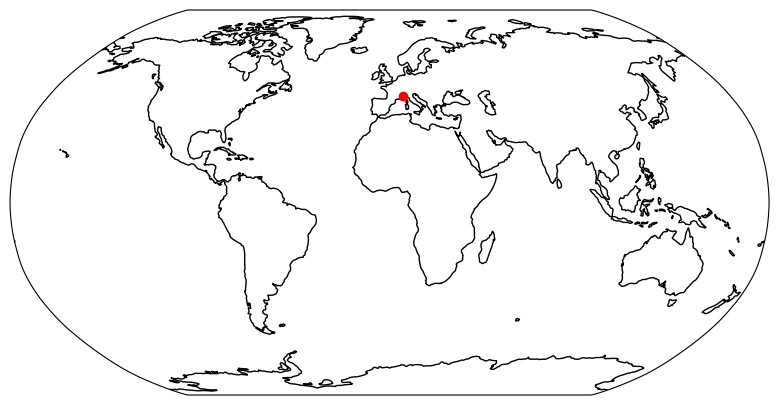

In [10]:
# Reproject to a projected CRS
gdf_projected = gdf.to_crs(epsg=3857)
centroids = gdf_projected.centroid

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Make the map global rather than have it zoom in to the extents of any plotted data
ax.set_global()

# ax.stock_img()
ax.coastlines()

# Transform back to geographic CRS for plotting
gdf_centroids_geographic = centroids.to_crs(epsg=4326)

ax.plot(
    gdf_centroids_geographic.x,
    gdf_centroids_geographic.y,
    "ro",
    transform=ccrs.PlateCarree(),
)

plt.show()

## Compute radiances


From: https://s2.pages.eopf.copernicus.eu/pdfs-adfs/MSI/L1/PDFS_S2_MSI_L1C.myst.html#product-overview

$\text{radiance} = \text{reflectance} \times \cos\left(\text{radians}(\text{SunZenithAngle})\right) \times \text{solarIrradiance} \times \frac{U}{\pi}$
$
\]


In [11]:
U: float = dt.attrs["other_metadata"][
    "reflectance_correction_factor_from_the_Sun-Earth_distance_variation_computed_using_the_acquisition_date"
]
U

1.03411047670495

Be carefull, Sun Zenith Angle is expressed on the angles grid (5km), it needs to be reprojected on the 10m grid for computing radiances cosinus is applied now because we can not interpolate angles using a linear interpolation (discontinuity at 0°).  
On the other hand, cosines can be interpolated:

In [12]:
cos_sza_5km: EOVariable = np.cos(np.deg2rad(dt["conditions/geometry/sun_angles"])).sel(
    angle="zenith"
)
cos_sza_5km

<xarray.DataArray 'sun_angles' (y: 23, x: 23)> Size: 4kB
dask.array<getitem, shape=(23, 23), dtype=float64, chunksize=(23, 23), chunktype=numpy.ndarray>
Coordinates:
    angle    <U7 28B 'zenith'
  * x        (x) int64 184B 300000 305000 310000 315000 ... 400000 405000 410000
  * y        (y) int64 184B 5000040 4995040 4990040 ... 4900040 4895040 4890040
Attributes:
    _eopf_attrs:  {'coordinates': ['angle', 'y', 'x'], 'dimensions': ['angle'...

In [13]:
# We will convert reflectances from band b02 to radiances
BAND: int = 2  # b02

# Band - 1 because Python list index starts at 0
solarIrradiance: float = np.float64(
    dt.attrs["stac_discovery"]["properties"]["bands"][BAND - 1]["solar_illumination"]
)

reflectance_b02_10m: EOVariable = dt["measurements/reflectance/r10m"]["b02"]
reflectance_b02_10m

<xarray.DataArray 'b02' (y: 10980, x: 10980)> Size: 964MB
dask.array<open_dataset-b02, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
Attributes:
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    dtype:           <u2
    fill_value:      0
    long_name:       TOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [300000.0, 4890240.0, 409800.0, 5000040.0]
    proj:epsg:       32632
    proj:shape:      [10980, 10980]
    proj:transform:  [10.0, 0.0, 300000.0, 0.0, -10.0, 5000040.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    units:           digital_counts
    valid_max:       65535
    valid_min:       1

Interpolate sza on the angles grid to the 10m grid, using the xarray `.interp_like()` method, which interpolates our input data to match the given target.

In [14]:
cos_sza_10m: xr.DataArray = cos_sza_5km.interp_like(reflectance_b02_10m)
cos_sza_10m.compute()

<xarray.DataArray 'sun_angles' (y: 10980, x: 10980)> Size: 964MB
array([[0.37259027, 0.37259063, 0.37259099, ..., 0.37644357, 0.37644392,
        0.37644427],
       [0.37259171, 0.37259206, 0.37259242, ..., 0.376445  , 0.37644535,
        0.3764457 ],
       [0.37259314, 0.37259349, 0.37259385, ..., 0.37644643, 0.37644678,
        0.37644712],
       ...,
       [0.38824467, 0.38824502, 0.38824538, ..., 0.39208391, 0.39208426,
        0.3920846 ],
       [0.38824609, 0.38824645, 0.3882468 , ..., 0.39208533, 0.39208568,
        0.39208602],
       [0.38824751, 0.38824787, 0.38824822, ..., 0.39208675, 0.3920871 ,
        0.39208744]])
Coordinates:
    angle    <U7 28B 'zenith'
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
Attributes:
    _eopf_attrs:  {'coordinates': ['angle', 'y', 'x'], 'dimensions': ['angle'...

For simplicity, radiance computation assume that reflectances equal numerical counts

In [15]:
radiance = reflectance_b02_10m * cos_sza_10m * solarIrradiance * U / np.pi
radiance

<xarray.DataArray (y: 10980, x: 10980)> Size: 964MB
dask.array<truediv, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
    angle    <U7 28B 'zenith'

## Visualization

Visualize Dask computational graph to compute radiance values. For more info, see the Dask docs: https://docs.dask.org/en/stable/graphviz.html#visualize-task-graphs

In [16]:
radiance.data.visualize()

Visualize the resulting radiance values

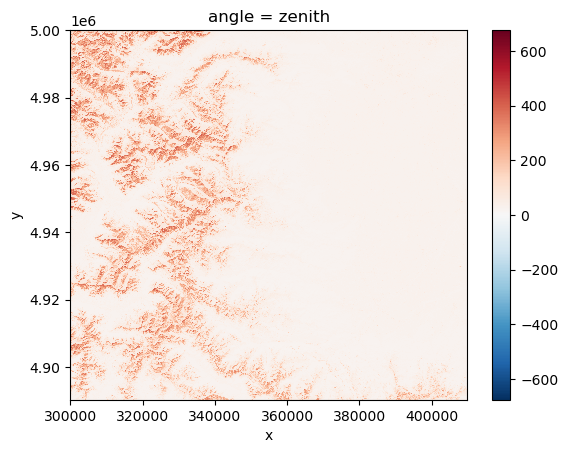

In [17]:
radiance.plot()

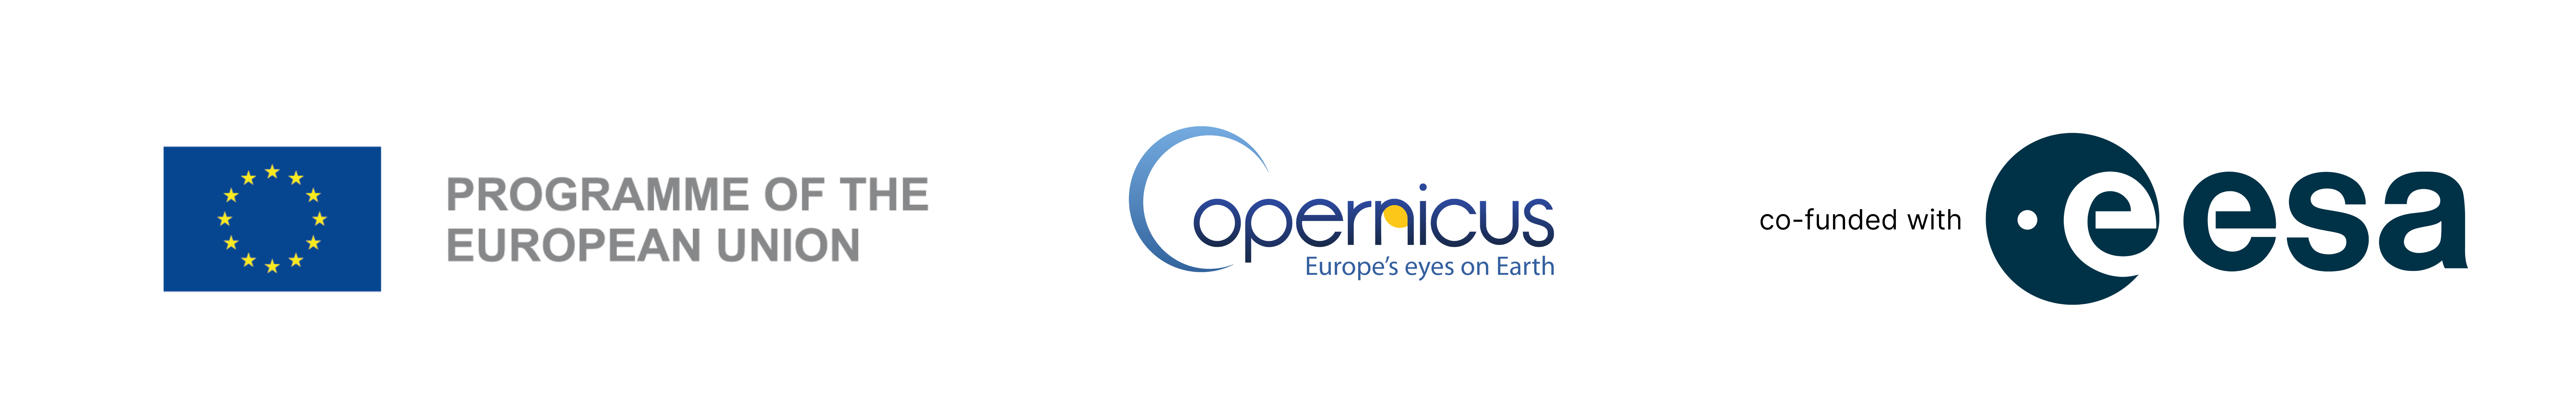